## Configure the model

In [3]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
model = ChatGroq(model_name="deepseek-r1-distill-llama-70b", temperature=0.1)

# from langchain_google_genai import ChatGoogleGenerativeAI
# model=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

output=model.invoke("What is the capital of France?")
print(output.content)

<think>

</think>

The capital of France is Paris.


In [4]:
import operator
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode


## Define Node functions

In [5]:
def call_model(state:MessagesState) -> MessagesState:
    message = state['messages']
    response = model.invoke(message)
    return {"messages":[response]}

state={"messages":['What is the capital of France?']}
call_model(state)

{'messages': [AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.048189766, 'prompt_time': 0.000254185, 'queue_time': 0.053864356, 'total_time': 0.048443951}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d5ff4eea-7b80-4f89-b6f5-3a8a6fffe522-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})]}

## Create StateGraph workflow

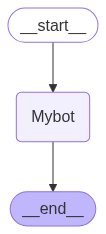

In [6]:
workflow = StateGraph(MessagesState)
workflow.add_node("Mybot",call_model)
workflow.add_edge(START, "Mybot")
workflow.add_edge("Mybot", END)
app=workflow.compile()

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
input = {"messages": ["Hi hello how are you?"]}
app.invoke(input)

{'messages': [HumanMessage(content='Hi hello how are you?', additional_kwargs={}, response_metadata={}, id='0632015e-9f7c-48b5-89d5-7090260bcf32'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.189281621, 'prompt_time': 0.000183307, 'queue_time': 0.053380308, 'total_time': 0.189464928}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--59ab53d7-bba8-4915-ae55-0fb7cf30dc70-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})]}

### Create Tools and design workflow with tools

In [8]:
@tool
def search(query:str):
    """"This is my custom toom for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

search.invoke("What is temp in kashmir?")

'the temp is 25 degree and cloudy'

In [9]:
## LLM Response without Tool
respons=model.invoke("What is the temp in delhi?")
print(respons.content)

## LLM Response with Tool
# Gemini models (like those in langchain_google_genai) currently have limited or no support for function/tool calling via `bind_tools`.
# This means that even after binding tools, Gemini may not invoke your custom tool as expected.
# For reliable tool/function calling, use models that officially support this feature (e.g., OpenAI GPT-4, some Groq models).
# See: https://python.langchain.com/docs/integrations/chat/google_gemini/#limitations



<think>

</think>

As of my last update in July 2024, I cannot provide real-time information. To find the current temperature in Delhi, you can check a reliable weather service like [AccuWeather](https://www.accuweather.com) or [Weather.com](https://www.weather.com), or use a virtual assistant like Siri, Google Assistant, or Alexa for real-time updates. Let me know if you'd like help with anything else!


In [12]:
# In summary: model.bind_tools(tools) does not work as expected with Gemini because Gemini's API does not yet support function/tool calling in the same way as OpenAI models.
tools=[search]
llm_with_tool=model.bind_tools(tools)  ## Bind the tool to the model
respons=llm_with_tool.invoke("What is the temp in delhi?")
print(respons.content)


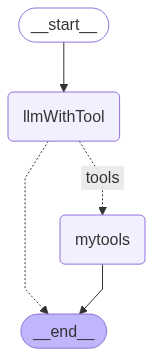

In [13]:
def call_model_with_tool(state:MessagesState) -> MessagesState:
    message = state['messages']
    response = llm_with_tool.invoke(message)
    return {"messages":[response]}

def router_function(state:MessagesState) -> MessagesState:
    message = state['messages']
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

tool_node = ToolNode(tools)

workflow1 = StateGraph(MessagesState)
workflow1.add_node("llmWithTool",call_model_with_tool)
workflow1.add_node("mytools",tool_node)
workflow1.add_edge(START, "llmWithTool")
workflow1.add_conditional_edges("llmWithTool",router_function,{"tools":"mytools", END:END})
app1=workflow1.compile()

from IPython.display import display, Image
display(Image(app1.get_graph().draw_mermaid_png()))

In [14]:
input = {"messages": ["What is the temp in delhi?"]}
app1.invoke(input)

{'messages': [HumanMessage(content='What is the temp in delhi?', additional_kwargs={}, response_metadata={}, id='9d9b67cf-2c5d-43a6-a391-7dbb60588d3e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '79wawax04', 'function': {'arguments': '{"query":"temp in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 135, 'total_tokens': 319, 'completion_time': 0.833224187, 'prompt_time': 0.008670021, 'queue_time': 0.054330759000000006, 'total_time': 0.841894208}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--09dccbbe-98df-4df5-8147-33a6814e13e0-0', tool_calls=[{'name': 'search', 'args': {'query': 'temp in delhi'}, 'id': '79wawax04', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 184, 'total_tokens': 319}),
  ToolMessage(content='the temp is 45 degree and sunny', name='sear

### Add loop to validate results of tools by LLM

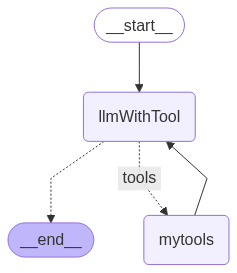

In [20]:
workflow2= StateGraph(MessagesState)
workflow2.add_node("llmWithTool",call_model_with_tool)
workflow2.add_node("mytools",tool_node)
workflow2.add_edge(START, "llmWithTool")
workflow2.add_conditional_edges("llmWithTool",router_function,{"tools":"mytools", END:END})
workflow2.add_edge("mytools","llmWithTool")
app2=workflow2.compile()

from IPython.display import display, Image

display(Image(app2.get_graph().draw_mermaid_png()))

In [22]:
## Streaming the output
for output in app2.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")
    

here is output from llmWithTool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0aqrqyzz7', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 182, 'prompt_tokens': 136, 'total_tokens': 318, 'completion_time': 0.745931791, 'prompt_time': 0.008657306, 'queue_time': 0.05631694799999999, 'total_time': 0.754589097}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4f49d25-725a-4b2c-8684-986061f65eab-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in New Delhi'}, 'id': '0aqrqyzz7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 136, 'output_tokens': 182, 'total_tokens': 318})]}


here is output from mytools
_______
{'messages': [ToolMessage(content='the temp is 45 degree and sunny', name='search', id='6534c5c5-92f9-4b2e-bb4c-11a3

### Add memory to graph

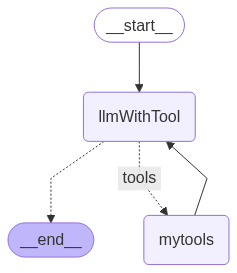

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

workflow3= StateGraph(MessagesState)
workflow3.add_node("llmWithTool",call_model_with_tool)
workflow3.add_node("mytools",tool_node)
workflow3.add_edge(START, "llmWithTool")
workflow3.add_conditional_edges("llmWithTool",router_function,{"tools":"mytools", END:END})
workflow3.add_edge("mytools","llmWithTool")
app3=workflow3.compile(checkpointer=memory) ## Use MemorySaver to save the state of the workflow

from IPython.display import display, Image
display(Image(app3.get_graph().draw_mermaid_png()))

In [28]:
## Streaming the output with MemorySaver
config={"configurable": {"thread_id": "1"}}
events=app3.stream(
    {"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values"
    )

## printing the events
for event in events:
    event["messages"][-1].pretty_print()

events=app3.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

## printing the events
for event in events:
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (rfb71czev)
 Call ID: rfb71czev
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny
================================== Ai Message ==================================

The current weather in New Delhi is 45 degrees and sunny.
================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (8axkh3yh6)
 Call ID: 8axkh3yh6
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy
================================== 

In [ ]:
## To retrieve the state of the workflow from memory
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T13:32:40.675064+00:00',
 'id': '1f049240-b5c8-6e64-8016-a281aa010784',
 'channel_versions': {'__start__': '00000000000000000000000000000019.0.6872444288139242',
  'messages': '00000000000000000000000000000024.0.5907020946598442',
  'branch:to:llmWithTool': '00000000000000000000000000000024.0.8057812296101525',
  'branch:to:mytools': '00000000000000000000000000000023.0.09638059269994936'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000018.0.7594459387814108'},
  'llmWithTool': {'branch:to:llmWithTool': '00000000000000000000000000000023.0.3779490946349435'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000022.0.35296240133392576'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='98a55b2e-73c5-4e34-8a70-e6dcbf469385'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zfkacxtnr', 'function':

In [31]:
# Streaming the output with MemorySaver for a different query
events=app3.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

## printing the events
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The temperature was 25 degrees in **Indore**.
